<center>
<h1>Sprint 3</h1>
<b>Sistema de Recomendación</b>
</center>

<b>Grupo: </b>
<ul>
  <li>Cornelio Edgardo</li>
  <li>Parra Iván</li>
</ul>

# Enunciado: 3er entrega - Sistemas de recomendación

En esta entrega vamos a trabajar con un sistema de recomendación.

Vamos a aprovechar la competencia de Telecom que vimos ya que los datos son reales y están buenos para practicar.

En el siguiente repositorio pueden encontrar el significado de cada columna de los datasets:
https://github.com/Datathon2021/Recomendador

Consigna:

- Dividir set en train y test. Tomar como train los datos hasta el 1 de marzo de 2021. Desde el 1ro de marzo en adelante, reservar para test.
- Desarrollar un recomendador. El recomendador debe ser capaz de generar recomendaciones para TODOS los usuarios (incluyendo los cold start que no tengan visualizaciones en el set de train). Generar 20 recomendaciones por usuario.
- Las recomendaciones tienen que ser para cada account_id y hay que recomendar content_id (NO asset_id). Pueden encontrar esto en el repositorio de la competencia.
- Los contenidos que recomienden, no tienen que haber sido vistos previamente por los usuarios (filtrar).
- Evaluarlo con MAP.

Recomendaciones:
- En este caso no tenemos ratings explícitos como los casos que vimos, deben generar ustedes estos ratings mediante algún criterio. Lo más simple podría ser utilizar ratings binarios (lo vió / no lo vió).
- Hay una columna que nos indica hasta cuando va a estar disponible el contenido
- La columna **end_vod_date**: "fecha de finalización de la disponibilidad del activo en la plataforma" puede llegar a serles muy útil. ¿Tiene sentido recomendar algo que no va a estar disponible en el set de test? (a partir del 1 de marzo de 2021).
- Comiencen con algo SIMPLE. No se compliquen con todas las columnas que tiene el dataset. No van a necesitar usar todas, muchas columnas podrán descartarlas dependiendo del enfoque que tomen.

Datos:
- https://drive.google.com/file/d/1QjbqJvU0PTClEhReOyzr96BS-HpyyUKT/view?usp=sharing
- https://drive.google.com/file/d/1ih6SZc44w8FXdFKQJ2l-aqEWFpfceGuN/view?usp=sharing

Fecha de entrega: **30 de Enero de 2023**.

Subir a un repositorio de github (público) y enviar el link a alexispacek@gmail.com. De paso les sirve para ir armando su perfil de github con algunos proyectos 😉.



In [2]:
# Los de siempre
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# datetime
from datetime import datetime

# matrices
from scipy.sparse import csr_matrix

# models
from lightfm import LightFM

Modo oscuro en Jupyter Notebook

In [93]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

Si hay problemas con la instalación de lightfm, abrir consola de conda y ejecutar lo siguiente:

In [ ]:
conda install -c conda-forge lightfm

Seteamos max_coldwidth

In [ ]:
pd.options.display.max_colwidth = 10000

# Exploratory Data Analysis (EDA)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Leemos train.csv y metadatos.csv

In [5]:
%%time
df_train = pd.read_csv('./train.csv', delimiter=',')
df_train.head(1)

CPU times: user 3.22 s, sys: 262 ms, total: 3.48 s
Wall time: 4.73 s


,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0


In [6]:
%%time
df_metadatos = pd.read_csv('./metadata.csv', delimiter=';')
df_metadatos.head(1)

CPU times: user 252 ms, sys: 34.6 ms, total: 287 ms
Wall time: 374 ms


,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",...,N,N,N,N,N,N,2017-12-01T10:18:15.0Z,2019-01-26T06:37:18.0Z,2017-12-01T00:00:00.0Z,2020-12-01T23:59:59.0Z


In [7]:
filas, columnas = df_train.shape
print("train.csv")
print(f"Cantidad de Filas: {filas}")
print(f"Cantidad de Columnas: {columnas}")

train.csv
Cantidad de Filas: 3657801
Cantidad de Columnas: 7


In [9]:
# Info de columnas
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657801 entries, 0 to 3657800
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  int64  
 1   account_id   int64  
 2   device_type  object 
 3   asset_id     float64
 4   tunein       object 
 5   tuneout      object 
 6   resume       int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 195.3+ MB


In [10]:
# Hay nulos?
print("nulos en train.csv")
df_train.isna().sum()

nulos en train.csv


customer_id     0
account_id      0
device_type    29
asset_id       22
tunein          0
tuneout         0
resume          0
dtype: int64

In [11]:
filas, columnas = df_metadatos.shape
print("metadatos.csv")
print(f"Cantidad de Filas: {filas}")
print(f"Cantidad de Columnas: {columnas}")

metadatos.csv
Cantidad de Filas: 33144
Cantidad de Columnas: 30


In [12]:
# Info de las columnas
df_metadatos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33144 entries, 0 to 33143
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   asset_id            33144 non-null  int64  
 1   content_id          33123 non-null  float64
 2   title               33144 non-null  object 
 3   reduced_title       33144 non-null  object 
 4   episode_title       28997 non-null  object 
 5   show_type           33140 non-null  object 
 6   released_year       33144 non-null  float64
 7   country_of_origin   33140 non-null  object 
 8   category            33144 non-null  object 
 9   keywords            33142 non-null  object 
 10  description         33142 non-null  object 
 11  reduced_desc        33144 non-null  object 
 12  cast_first_name     24412 non-null  object 
 13  credits_first_name  20590 non-null  object 
 14  run_time_min        33144 non-null  float64
 15  audience            33143 non-null  object 
 16  made

In [13]:
# Hay nulos?
print("nulos en metadatos.csv")
df_metadatos.isna().sum()

nulos en metadatos.csv


asset_id                  0
content_id               21
title                     0
reduced_title             0
episode_title          4147
show_type                 4
released_year             0
country_of_origin         4
category                  0
keywords                  2
description               2
reduced_desc              0
cast_first_name        8732
credits_first_name    12554
run_time_min              0
audience                  1
made_for_tv               0
close_caption             0
sex_rating                0
violence_rating           0
language_rating           0
dialog_rating             0
fv_rating                 0
pay_per_view              0
pack_premium_1            0
pack_premium_2            0
create_date               0
modify_date               0
start_vod_date            0
end_vod_date              0
dtype: int64

<b>Mergeamos los dos dataset por asset_id</b>

In [14]:
%%time
df = df_train.merge(df_metadatos, how="left", left_on="asset_id", right_on="asset_id")

CPU times: user 4.12 s, sys: 323 ms, total: 4.45 s
Wall time: 4.44 s


In [15]:
filas, columnas = df.shape
print("- dataset mergeado -")
print(f"Cantidad de Filas: {filas}")
print(f"Cantidad de Columnas: {columnas}")

- dataset mergeado -
Cantidad de Filas: 3657801
Cantidad de Columnas: 36


<b>Nos quedamos solo con los features que utilizaremos</b>

In [16]:
df = df[[ 
        # df_train
        'customer_id', 'account_id', 'device_type', 'asset_id', 'tunein', 'tuneout', 'resume', 
        # df_metadatos
        'content_id', 'title', 'show_type', 'country_of_origin', 'category', 'run_time_min', 'end_vod_date'
        ]]

In [17]:
filas, columnas = df.shape
print("- dataset mergeado -")
print(f"Cantidad de Filas: {filas}")
print(f"Cantidad de Columnas: {columnas}")

- dataset mergeado -
Cantidad de Filas: 3657801
Cantidad de Columnas: 14


<b>info y nulos del dataset</b>

In [18]:
# Info de las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3657801 entries, 0 to 3657800
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   customer_id        int64  
 1   account_id         int64  
 2   device_type        object 
 3   asset_id           float64
 4   tunein             object 
 5   tuneout            object 
 6   resume             int64  
 7   content_id         float64
 8   title              object 
 9   show_type          object 
 10  country_of_origin  object 
 11  category           object 
 12  run_time_min       float64
 13  end_vod_date       object 
dtypes: float64(3), int64(3), object(8)
memory usage: 418.6+ MB


In [19]:
# Hay nulos?
df.isna().sum()

customer_id            0
account_id             0
device_type           29
asset_id              22
tunein                 0
tuneout                0
resume                 0
content_id           142
title                 22
show_type             35
country_of_origin     40
category              22
run_time_min          22
end_vod_date          22
dtype: int64

In [20]:
# Porcentaje de nulos
df.isna().mean()*100

customer_id          0.000000
account_id           0.000000
device_type          0.000793
asset_id             0.000601
tunein               0.000000
tuneout              0.000000
resume               0.000000
content_id           0.003882
title                0.000601
show_type            0.000957
country_of_origin    0.001094
category             0.000601
run_time_min         0.000601
end_vod_date         0.000601
dtype: float64

<b>Elimininamos nulos</b>

In [21]:
%%time
print(f"Antes: {df.shape[0]}")
df = df.dropna()
print(f"Ahora: {df.shape[0]}")

Antes: 3657801
Ahora: 3657599
CPU times: user 1.12 s, sys: 48.1 ms, total: 1.17 s
Wall time: 1.16 s


<b>Eliminamos duplicados</b>

In [22]:
%%time
print(f"Antes: {df.shape[0]}")
df = df.drop_duplicates(keep='first')
print(f"Ahora: {df.shape[0]}")

Antes: 3657599
Ahora: 3657561
CPU times: user 4.36 s, sys: 254 ms, total: 4.61 s
Wall time: 4.63 s


<b>Convertimos 'tunein' a YYYYmmDD, ya que lo utilizaremos para hacer el split para train y test</b>

In [23]:
%%time
df['timestamp'] = pd.to_datetime(df['tunein'], format='%Y/%m/%d')
df['timestamp'] = df['timestamp'].dt.strftime('%Y/%m/%d')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y/%m/%d')
df[['tunein', 'timestamp']].head(1)

CPU times: user 17.2 s, sys: 79.4 ms, total: 17.2 s
Wall time: 17.2 s


,tunein,timestamp
0,2021-02-18 22:52:00.0,2021-02-18


<b>Calculamos los minutos de visualizacion del asset por el usuario</b>

In [24]:
%%time
df['from'] =  pd.to_datetime(df['tunein'], format='%Y-%m-%d %H:%M:%S.%f')
df['to'] =  pd.to_datetime(df['tuneout'], format='%Y-%m-%d %H:%M:%S.%f')
df['resultado'] = df['to'] - df['from']
df['minutos_vistos'] = df['resultado'].dt.seconds.div(60).astype(float) 
df[['from','to','resultado','minutos_vistos']].head(2)

CPU times: user 986 ms, sys: 59.5 ms, total: 1.05 s
Wall time: 1.04 s


,from,to,resultado,minutos_vistos
0,2021-02-18 22:52:00,2021-02-18 23:35:00,0 days 00:43:00,43.0
1,2021-03-24 23:17:00,2021-03-25 00:01:00,0 days 00:44:00,44.0


<b>Feature 'end_vod_date' de object a date</b>

In [25]:
df['end_vod_date'] = pd.to_datetime(df['end_vod_date'], format='%Y/%m/%d')
df["end_vod_date"] = pd.to_datetime(df["end_vod_date"]).dt.date

<b>Fecha mínima y máxima del dataset</b>

In [26]:
print(f"Fecha mínimima: {df.timestamp.min()}")
print(f"Fecha máxima: {df.timestamp.max()}")

Fecha mínimima: 2021-01-01 00:00:00
Fecha máxima: 2021-03-31 00:00:00


<b>Clientes y Perfiles</b>

In [27]:
print(f'Número de clientes: {df["customer_id"].nunique()}')
print(f'Número de perfiles: {df["account_id"].nunique()}')

Número de clientes: 112332
Número de perfiles: 113873


In [28]:
# Perfiles por cliente
df_copy = df[['customer_id','account_id']].copy()
print(df_copy.shape)
df_copy = df_copy.drop_duplicates(keep='first')
print(df_copy.shape)
print("")
print(df_copy.groupby('customer_id').size() \
    .sort_values(ascending=False))
print("")
print("Vemos que el nro max de perfiles por cliente es de 3 y el mínimo de 1.")

(3657561, 2)
(113873, 2)

customer_id
55768     3
99513     3
80283     3
100109    3
23884     3
         ..
74612     1
74613     1
74614     1
74615     1
0         1
Length: 112332, dtype: int64

Vemos que el nro max de perfiles por cliente es de 3 y el mínimo de 1.


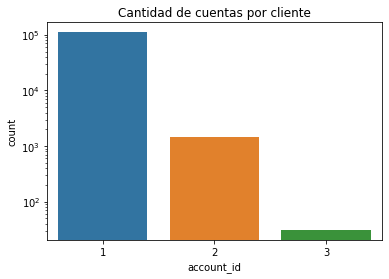

In [29]:
accounts_per_customer = df.groupby('customer_id').agg({'account_id': 'nunique'}).account_id

plt.figure()
plt.title("Cantidad de cuentas por cliente")
sns.countplot(x=accounts_per_customer)
plt.yscale('log')
plt.show()

<i>Vemos que la mayoría de los clientes tiene una sola cuenta.</i>

In [30]:
accounts_per_customer.value_counts()

1    110822
2      1479
3        31
Name: account_id, dtype: int64

<b>Assets y contenidos</b>

In [31]:
print(f'Número de contents: {df["content_id"].nunique()}')
print(f'Número de assets: {df["asset_id"].nunique()}')

Número de contents: 4061
Número de assets: 23973


In [32]:
df_copy = df[['content_id','asset_id']].copy()
df_copy = df_copy.drop_duplicates(keep='first')
aux = df_copy.groupby('content_id').size() \
            .sort_values(ascending=False)
print("Cantidad de assets por content_id")
print("")
print(aux)
print("")
print("Vemos que el nro max de assets por contenido es de 205.")

Cantidad de assets por content_id

content_id
1879.0    205
176.0     195
387.0     171
1769.0    170
1573.0    168
         ... 
3608.0      1
3609.0      1
3610.0      1
3612.0      1
4371.0      1
Length: 4061, dtype: int64

Vemos que el nro max de assets por contenido es de 205.


<b>Cantidad de visualizaciones por año:</b>

In [33]:
plot_df = df.copy()
plot_df["year"] = plot_df.timestamp.dt.year
plot_df = plot_df.groupby("year", as_index=False).count()[["year", "customer_id"]]
plot_df.columns = ["year", "visualizations_count"]
plot_df.head()

,year,visualizations_count
0,2021,3657561


<b>Cantidad de visualizaciones por mes:</b>

In [34]:
plot_df = df.copy()
plot_df["month"] = plot_df.timestamp.dt.month
plot_df = plot_df.groupby("month", as_index=False).count()[["month", "customer_id"]]
plot_df.columns = ["month", "visualizations_count"]
plot_df.head()

,month,visualizations_count
0,1,1216404
1,2,1122548
2,3,1318609


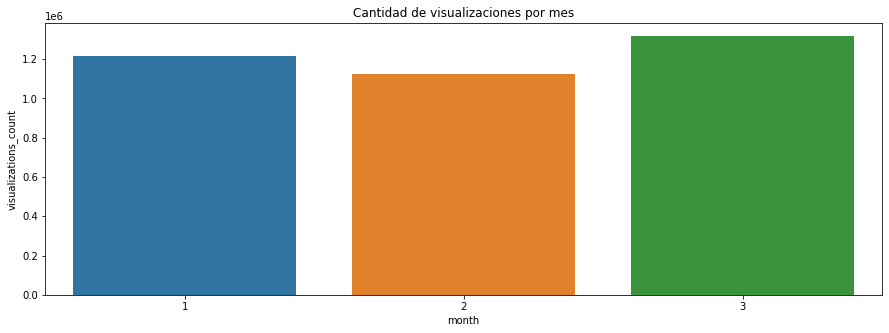

In [35]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x=plot_df.month, y=plot_df.visualizations_count)
plt.title("Cantidad de visualizaciones por mes")
plt.show()

<b>Cantidad de visualizaciones por tipo de dispositivo</b>

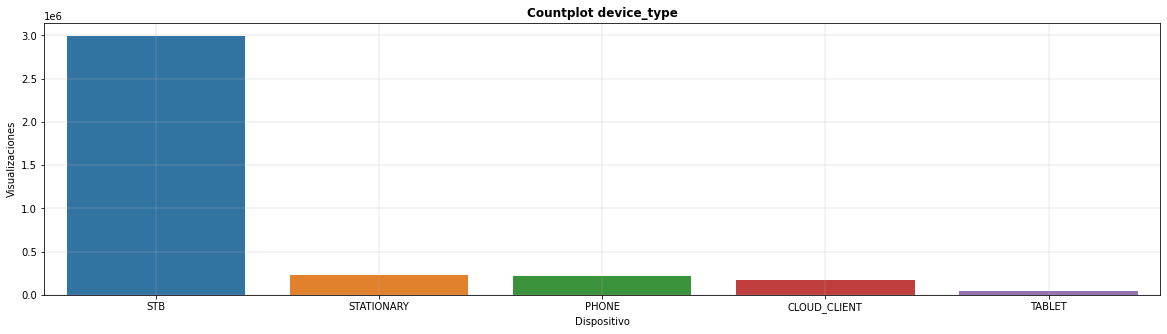

In [33]:
plt.figure(figsize=(20, 5))
ax = sns.countplot(data=df, x='device_type', order=df['device_type'].value_counts().iloc[:10].index)
# for container in ax.containers:
  #  ax.bar_label(container)
plt.xlabel('Dispositivo')
plt.ylabel('Visualizaciones')
plt.grid(linewidth=0.3)
plt.title('Countplot device_type', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

In [34]:
df.device_type.value_counts()

STB             2993374
STATIONARY       224697
PHONE            216460
CLOUD_CLIENT     174519
TABLET            48511
Name: device_type, dtype: int64

<i>La mayor parte de las reproducciones son desde el decodificador de flow (STB)</i>

<b>Cantidad de visualizaciones por country_of_origin</b>

In [46]:
df_country = df.groupby(['content_id','country_of_origin'])['asset_id'].size().reset_index()
df_country = df_country.drop_duplicates(subset=['content_id', 'country_of_origin'], keep='last') 

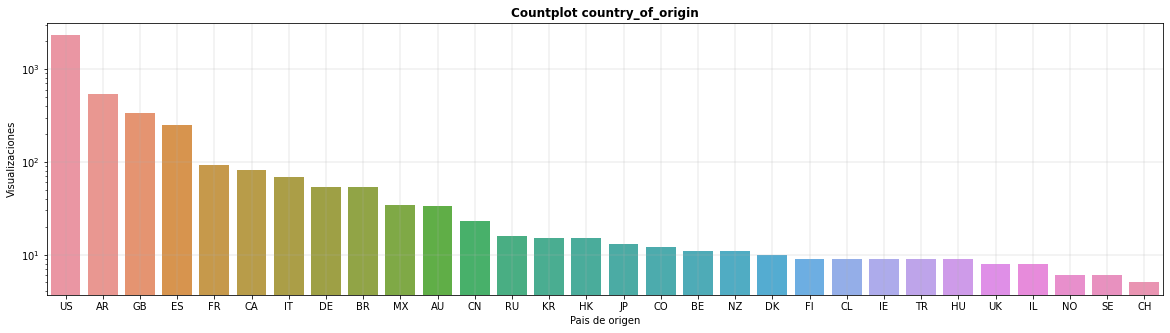

In [54]:
plt.figure(figsize=(20, 5))
ax = sns.countplot(data=df_country, x='country_of_origin', order=df_country['country_of_origin'].value_counts().iloc[:30].index)
# for container in ax.containers:
  #  ax.bar_label(container)
plt.xlabel('Pais de origen')
plt.ylabel('Visualizaciones')
ax.set(yscale="log")
plt.grid(linewidth=0.3)
plt.title('Countplot country_of_origin', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

In [57]:
df_country.country_of_origin.value_counts()[:10]

US    2307
AR     541
GB     337
ES     250
FR      92
CA      82
IT      69
DE      54
BR      53
MX      34
Name: country_of_origin, dtype: int64

<b>Cantidad de visualizaciones por tipo</b>

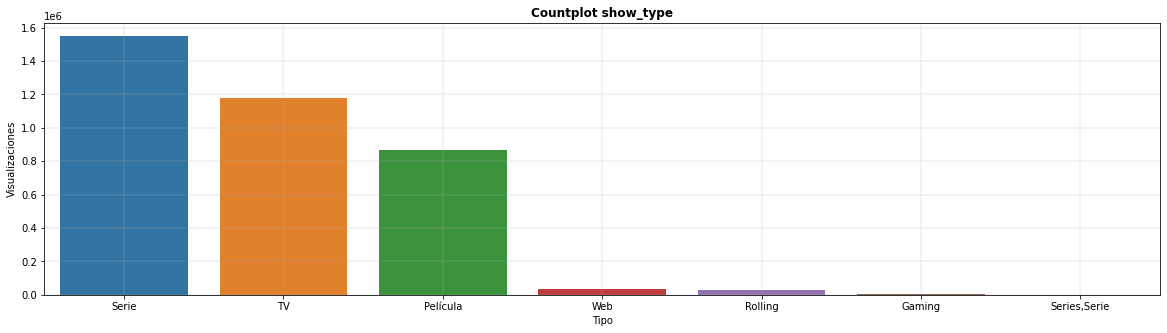

In [41]:
plt.figure(figsize=(20, 5))
ax = sns.countplot(data=df, x='show_type', order=df['show_type'].value_counts().iloc[:30].index)
# for container in ax.containers:
  #  ax.bar_label(container)
plt.xlabel('Tipo')
plt.ylabel('Visualizaciones')
plt.grid(linewidth=0.3)
plt.title('Countplot show_type', fontdict={'fontsize': 12,'fontweight':'bold'})
plt.show()

In [42]:
df.show_type.value_counts()

Serie           1549986
TV              1178457
Película         867207
Web               32706
Rolling           26273
Gaming             2878
Series,Serie         54
Name: show_type, dtype: int64

<i>Vemos que el último show type corresponde a 'Series,Serie', por lo que decidimos agruparlos en Serie</i>

In [43]:
df['show_type'] = df['show_type'].apply(lambda x: 'Serie' if x == 'Series,Serie' else x)

<b>Cantidad de visualizaciones por perfil:</b>

In [48]:
df.groupby(['customer_id','account_id'])['minutos_vistos'].size() \
    .sort_values(ascending=False)

customer_id  account_id
36854        7107          3612
79889        99113         2256
110394       24556         1836
66280        84543         1692
82636        102343        1631
                           ... 
45017        63925            1
45056        63962            1
9852         92611            1
45061        63966            1
101201       17563            1
Name: minutos_vistos, Length: 113873, dtype: int64

Cantidad de visualizaciones por perfil y content_id:

In [49]:
df.groupby(['customer_id','account_id','content_id'])['minutos_vistos'].size() \
    .sort_values(ascending=False)

customer_id  account_id  content_id
36854        7107        491.0         1885
109693       3042        562.0         1246
46409        65203       712.0         1242
25204        46522       1139.0        1187
32154        52503       2160.0        1104
                                       ... 
51330        69739       3329.0           1
                         3021.0           1
                         2259.0           1
84019        104007      1502.0           1
58814        76671       1986.0           1
Name: minutos_vistos, Length: 971443, dtype: int64

In [50]:
# Vemos los features del primer registro anterior.
df[(df['customer_id'] == 36854) & ( df['account_id']==7107) & (df['content_id']==491)].head(3)

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,content_id,title,show_type,country_of_origin,category,run_time_min,end_vod_date,timestamp,from,to,resultado,minutos_vistos
1087982,36854,7107,STB,15150.0,2021-01-01 08:46:00.0,2021-01-01 08:49:00.0,0,491.0,T:1 Ep:01 La Granja de Zenón: La Serie,TV,AR,Infantil/Dibujos Animados,3.0,2021-09-17,2021-01-01,2021-01-01 08:46:00,2021-01-01 08:49:00,0 days 00:03:00,3.0
1087983,36854,7107,STB,31410.0,2021-01-01 08:50:00.0,2021-01-01 08:53:00.0,0,491.0,T:1 Ep:02 La Granja de Zenón: La Serie,TV,AR,Infantil/Dibujos Animados,3.0,2021-09-17,2021-01-01,2021-01-01 08:50:00,2021-01-01 08:53:00,0 days 00:03:00,3.0
1088006,36854,7107,STB,15150.0,2021-01-02 12:42:00.0,2021-01-02 12:45:00.0,1,491.0,T:1 Ep:01 La Granja de Zenón: La Serie,TV,AR,Infantil/Dibujos Animados,3.0,2021-09-17,2021-01-02,2021-01-02 12:42:00,2021-01-02 12:45:00,0 days 00:03:00,3.0


In [51]:
# Sumamos los minutos que vio el perfil 7107 sobre el video 491
print('Sumamos los minutos que vio el perfil 7107 sobre el video 491')
df[( df['account_id']==7107) & (df['content_id']==491)].groupby(['customer_id','account_id','content_id','asset_id'])['minutos_vistos'].sum() \
    .sort_values(ascending=False)

Sumamos los minutos que vio el perfil 7107 sobre el video 491


customer_id  account_id  content_id  asset_id
36854        7107        491.0       24096.0     774.0
                                     11479.0     715.0
                                     6805.0      708.0
                                     31410.0     630.0
                                     31895.0     577.0
                                     29759.0     567.0
                                     15143.0     427.0
                                     5757.0      402.0
                                     16228.0     387.0
                                     30710.0     386.0
                                     3205.0      302.0
                                     15150.0     273.0
Name: minutos_vistos, dtype: float64

In [52]:
# vemos cuanto dura el video anterior.
df_metadatos[(df_metadatos['content_id']==491)].groupby(['content_id'])['run_time_min'].sum() \
    .sort_values(ascending=False)

content_id
491.0    72.0
Name: run_time_min, dtype: float64

<b>Duración de los assets</b>

In [53]:
print(f"Duracion mínima de un video: {df['run_time_min'].min()}")
print(f"Duracion máxima de un video: {df['run_time_min'].max()}")


print(f"Cantidad de videos con duracion mínima: {df[df['run_time_min'] == df['run_time_min'].min()].count().iloc[1]}")
print(f"Cantidad de videos con duracion máxima: {df[df['run_time_min'] == df['run_time_min'].max()].count().iloc[1]}")


Duracion mínima de un video: 0.0
Duracion máxima de un video: 305.0
Cantidad de videos con duracion mínima: 310
Cantidad de videos con duracion máxima: 11


<b>Visualizaciones por Mes</b>

In [54]:
def getNombreMes(mes):
    if( mes == 1 ): return "Enero"
    if( mes == 2 ): return "Febrero"
    if( mes == 3 ): return "Marzo"
    return "NoDisponible"

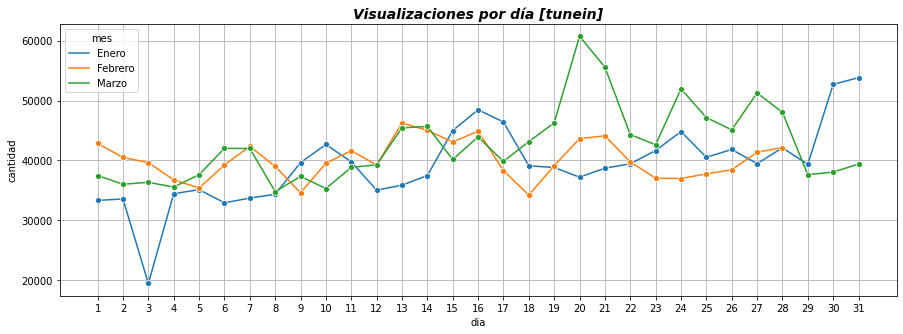

In [55]:
df_visualizaciones = df.copy()

df_visualizaciones['dia'] = df['timestamp'].dt.day
df_visualizaciones['mes'] = df['timestamp'].dt.month
df_visualizaciones['mes'] = df_visualizaciones['mes'].apply(getNombreMes)

df_visualizaciones = df_visualizaciones.groupby(['mes', 'dia'], as_index=False).count()[['mes', 'dia', 'asset_id']]
df_visualizaciones.rename(columns={'asset_id':'cantidad'}, inplace=True)

plt.figure(figsize=(15,5))
sns.lineplot(data=df_visualizaciones, x='dia', y='cantidad', hue='mes',  marker="o")
plt.title('Visualizaciones por día [tunein]', fontdict={'fontsize': 14,'fontweight':'bold', 'style':'italic'})
plt.xticks([x for x in range(df_visualizaciones['dia'].min(), df_visualizaciones['dia'].max() +1,1)])
plt.grid(0.6)
plt.show()

<b>¿Cuántas categorías distintas vio cada cuenta?</b>

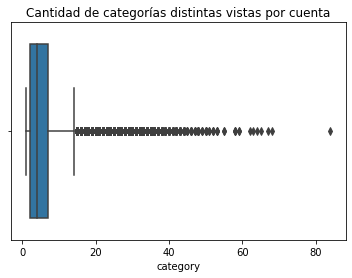

In [56]:
categories = df[['account_id', 'category']].groupby('account_id').agg({'category': 'nunique'})
plt.figure()
plt.title("Cantidad de categorías distintas vistas por cuenta")
sns.boxplot(x=categories.category)
plt.show()

In [57]:
categories.category.min()

1

In [58]:
categories.category.max()

84

In [59]:
categories.category.mean()

5.312479692288778

In [60]:
categories.category.median()

4.0

# Calculamos el rating

 <b>Opcion 1: Baseline </b>

Si vió el contenido entonces le gusto.

In [61]:
df['rating_1'] = 1

In [62]:
df.rating_1.value_counts()

1    3657561
Name: rating_1, dtype: int64

<b>Opcion 2: Campo RESUME</b>

Si el campo 'resume' es 1, es decir, volvió a ver el contenido, entonces le gusto.

In [63]:
df['rating_2'] = df.resume.apply(lambda x : 1 if x == 1 else 0)

In [64]:
df.rating_2.value_counts()

0    2192395
1    1465166
Name: rating_2, dtype: int64

<b>Opción 3: Porcentajes de visualización</b>

Si vio más del 30% de la duración del asset, entonces significa que le gusto.

In [65]:
df['rating_3'] = df['run_time_min'] * 0.3 - df['minutos_vistos'] 
df['rating_3'] = df['rating_3'].apply(lambda x: 1 if x <= 0 else 0)

In [66]:
df.rating_3.value_counts()

1    2433708
0    1223853
Name: rating_3, dtype: int64

<b>Opción 4: Porcentaje de visualización total</b>

La idea es calcular el porcentaje de visualización total de cada perfil respecto a cada contentido. Si este porcentaje supera el "X%", entonces significa que le gusto el contenido,por ende el rating es 1. Tomamos X = 40.

In [96]:
def calcular(content_id):
    return df_duracion[df_duracion.content_id == content_id].iloc[0]['run_time_min']

In [97]:
df_duracion = df_metadatos.groupby('content_id').agg({'run_time_min': 'sum'}).reset_index()

In [113]:
df_r4 = df.groupby(['account_id','content_id']).agg({'minutos_vistos':'sum'}).reset_index()

In [115]:
%%time
df_r4['duracion'] = df_r4.content_id.apply(calcular)

Wall time: 4min 33s


In [116]:
%%time
df_r4['porcentaje'] = df_r4.minutos_vistos * 100 / df_r4.duracion

Wall time: 15 ms


In [117]:
%%time
df_r4['rating'] = df_r4.porcentaje.apply(lambda x : 1 if x > 40 else 0)

Wall time: 359 ms


In [118]:
def buscar_rating(account_id, content_id):
    return df_r4[(df_r4.account_id == account_id) &(df_r4.content_id == content_id)].iloc[0]['rating']

<b>Opción 5: Opción 2 + Opción 3</b>

Esta opción involucra la opción 2 y opción 3, y sigue la siguiente lógica: si el usuario visualiza más de "x" minutos respecto a la duración del asset, entonces su rating será 1. También será 1 si resume = 1, es decir, que volvió a ver el contenido.

In [68]:
df['rating_5'] = df['run_time_min'] * 0.3 - df['minutos_vistos'] 
df['rating_5'] = df['rating_5'].apply(lambda x: 1 if x <= 0 else 0)
df['rating_5'] = (df['rating_5'] + df['resume']).apply(lambda x: 0 if x == 0 else 1)

In [69]:
df.rating_5.value_counts()

1    3169753
0     487808
Name: rating_5, dtype: int64

# Train - Test Split y Matriz de Interacción

Al momento de splitear puede ser que para un perfil y contenido el rating sea 'x' en una fila pero 'y' en otra. Por eso se decidió utilizar el promedio.

In [70]:
df_aux = df.groupby(['account_id', 'content_id'], as_index=False)\
            .agg({'account_id': 'first',
                  'content_id': 'first',
                  'rating_1': 'mean',
                  'rating_2': 'mean',
                  'rating_3': 'mean',
                  #'rating_4': 'mean',
                  'rating_5': 'mean',
                  })

df_aux.rename(columns = {'rating_1':'rating_1_aux','rating_2':'rating_2_aux','rating_3':'rating_3_aux','rating_5':'rating_5_aux'}, inplace=True)
print(len(df_aux))

971443


In [71]:
%%time
print(f'Número de filas antes de eliminar duplicados: {len(df)}')
df_main = df.drop_duplicates(subset=['account_id', 'content_id'], keep='last') 
print(f'Número de filas después de eliminar duplicados: {len(df_main)}') 

Número de filas antes de eliminar duplicados: 3657561
Número de filas después de eliminar duplicados: 971443
CPU times: user 309 ms, sys: 71.2 ms, total: 380 ms
Wall time: 372 ms


In [72]:
%%time
df_main = pd.merge(df_main, df_aux, how='inner', left_on=['account_id', 'content_id'], right_on=['account_id','content_id'])
df_main.drop(['rating_1','rating_2','rating_3','rating_5'], axis=1, inplace=True)
df_main.rename(columns = {'rating_1_aux':'rating_1','rating_2_aux':'rating_2','rating_3_aux':'rating_3','rating_5_aux':'rating_5'}, inplace=True)
print(len(df_main))

971443
CPU times: user 1.05 s, sys: 100 ms, total: 1.15 s
Wall time: 1.15 s


In [73]:
df_main.head(1)

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,content_id,title,show_type,...,timestamp,from,to,resultado,minutos_vistos,rating_4,rating_1,rating_2,rating_3,rating_5
0,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0,2040.0,T:5 Ep:10 This is Us,Serie,...,2021-03-24,2021-03-24 23:17:00,2021-03-25 00:01:00,0 days 00:44:00,44.0,1,1,0,1,1


In [119]:
%%time
df_main['rating_4'] = df_main.apply(lambda x : buscar_rating(x.account_id, x.content_id), axis=1)

Wall time: 1h 19s


In [74]:
df_main[(df_main.content_id == 491) & (df_main.account_id == 7107)]


,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,content_id,title,show_type,...,timestamp,from,to,resultado,minutos_vistos,rating_4,rating_1,rating_2,rating_3,rating_5
280644,36854,7107,STB,29759.0,2021-03-31 18:38:00.0,2021-03-31 19:19:00.0,0,491.0,T:1 Ep:07 La Granja de Zenón: La Serie,TV,...,2021-03-31,2021-03-31 18:38:00,2021-03-31 19:19:00,0 days 00:41:00,41.0,1,1,1,1,1


In [75]:
ratings = df_main[['account_id', 'content_id', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5', 'timestamp']].copy()
ratings.head()

,account_id,content_id,rating_1,rating_2,rating_3,rating_4,rating_5,timestamp
0,90627,2040.0,1,0,1,1,1,2021-03-24
1,3387,1983.0,1,1,1,1,1,2021-03-15
2,3387,729.0,1,0,1,1,1,2021-03-16
3,3388,691.0,1,0,1,1,1,2021-01-05
4,3388,3487.0,1,1,0,1,1,2021-01-24


<b>Train</b>

In [76]:
# set de train
train = ratings[(ratings.timestamp < datetime(year=2021, month=3, day=1))]
train.head()

,account_id,content_id,rating_1,rating_2,rating_3,rating_4,rating_5,timestamp
3,3388,691.0,1,0,1,1,1,2021-01-05
4,3388,3487.0,1,1,0,1,1,2021-01-24
5,3388,3038.0,1,0,1,1,1,2021-02-08
6,3388,2100.0,1,1,1,1,1,2021-02-21
9,3389,604.0,1,0,1,1,1,2021-01-26


In [122]:
print(f"Filas y columnas de train: {train.shape}")
print(f"Número de perfiles distintos en train: {train.account_id.nunique()}")

Filas y columnas de train: (612071, 8)
Número de perfiles distintos en train: 95758


<b>Test</b>

In [78]:
# set de test
test = ratings[ratings.timestamp >= datetime(year=2021, month=3, day=1)][['account_id','content_id','timestamp']]
test.head()

,account_id,content_id,timestamp
0,90627,2040.0,2021-03-24
1,3387,1983.0,2021-03-15
2,3387,729.0,2021-03-16
7,3388,3386.0,2021-03-29
8,3388,2040.0,2021-03-30


In [79]:
print(f"Filas y columnas de test: {test.shape}")
print(f"Número de perfiles distintos en test: {test.account_id.nunique()}")

Filas y columnas de test: (359372, 3)
Número de perfiles distintos en test: 87623


<b>¿Tenemos usuarios que aparecen en test pero no en train?</b>

In [80]:
test[~test.account_id.isin(train.account_id.unique())].account_id.nunique()

18115

Como vemos, tenemos 18115 account_id que están en test pero no en train. Utilizaremos "cold start" al momento de recomendar contenidos a estos usuarios.

<b>Armamos la matriz de interacción.</b>

In [81]:
matrix_columns_1 = ["account_id","content_id", "rating_1"]
matrix_columns_2 = ["account_id","content_id", "rating_2"]
matrix_columns_3 = ["account_id","content_id", "rating_3"]
matrix_columns_4 = ["account_id","content_id", "rating_4"]
matrix_columns_5 = ["account_id","content_id", "rating_5"]

In [82]:
%%time
interactions_1 = train[matrix_columns_1]
interactions_2 = train[matrix_columns_2]
interactions_3 = train[matrix_columns_3]
interactions_4 = train[matrix_columns_4]
interactions_5 = train[matrix_columns_5]

interactions_1.head(1)

CPU times: user 20.5 ms, sys: 36 µs, total: 20.5 ms
Wall time: 18.9 ms


,account_id,content_id,rating_1
3,3388,691.0,1


In [83]:
def pivotear_df(interactions, matrix_columns):
    return pd.pivot_table(interactions[matrix_columns], index=matrix_columns[0], columns=matrix_columns[1], values=matrix_columns[2])

In [84]:
%%time
interactions_matrix_1 = pivotear_df(interactions_1, matrix_columns_1)
interactions_matrix_1.head() 

CPU times: user 10.4 s, sys: 2.88 s, total: 13.3 s
Wall time: 13.3 s


content_id,0.0,1.0,3.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,...,4357.0,4358.0,4359.0,4360.0,4361.0,4362.0,4363.0,4364.0,4365.0,4366.0
account_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
%%time
interactions_matrix_2 = pivotear_df(interactions_2, matrix_columns_2)

CPU times: user 6.79 s, sys: 2.27 s, total: 9.06 s
Wall time: 9.06 s


In [86]:
%%time
interactions_matrix_3 = pivotear_df(interactions_3, matrix_columns_3)

CPU times: user 29.8 s, sys: 6.23 s, total: 36 s
Wall time: 36 s


In [94]:
%%time
interactions_matrix_4 = pivotear_df(interactions_4, matrix_columns_4)

CPU times: user 5.08 s, sys: 3.72 s, total: 8.8 s
Wall time: 8.84 s


In [87]:
%%time
interactions_matrix_5 = pivotear_df(interactions_5, matrix_columns_5)

CPU times: user 12.6 s, sys: 4.44 s, total: 17 s
Wall time: 17 s


Completo los NaN con ceros

In [88]:
%%time
interactions_matrix_1 = interactions_matrix_1.fillna(0)
interactions_matrix_1.head()

CPU times: user 12.5 s, sys: 1.72 s, total: 14.2 s
Wall time: 14.2 s


content_id,0.0,1.0,3.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,...,4357.0,4358.0,4359.0,4360.0,4361.0,4362.0,4363.0,4364.0,4365.0,4366.0
account_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
%%time
interactions_matrix_2 = interactions_matrix_2.fillna(0)

CPU times: user 7.01 s, sys: 1.39 s, total: 8.4 s
Wall time: 8.42 s


In [90]:
%%time
interactions_matrix_3 = interactions_matrix_3.fillna(0)

CPU times: user 9.04 s, sys: 184 ms, total: 9.23 s
Wall time: 9.25 s


In [95]:
%%time
interactions_matrix_4 = interactions_matrix_4.fillna(0)

CPU times: user 15.5 s, sys: 2.75 s, total: 18.3 s
Wall time: 18.3 s


In [91]:
%%time
interactions_matrix_5 = interactions_matrix_5.fillna(0)

CPU times: user 7.22 s, sys: 0 ns, total: 7.22 s
Wall time: 7.22 s


¿Cuántas filas y columnas tiene la matriz de interacción?

In [96]:
print(f"Matriz 1 tiene : {interactions_matrix_1.shape[0]} filas y {interactions_matrix_1.shape[1]} columnas")
print(f"Matriz 2 tiene : {interactions_matrix_2.shape[0]} filas y {interactions_matrix_2.shape[1]} columnas")
print(f"Matriz 3 tiene : {interactions_matrix_3.shape[0]} filas y {interactions_matrix_3.shape[1]} columnas")
print(f"Matriz 4 tiene : {interactions_matrix_4.shape[0]} filas y {interactions_matrix_4.shape[1]} columnas")
print(f"Matriz 5 tiene : {interactions_matrix_5.shape[0]} filas y {interactions_matrix_5.shape[1]} columnas")

Matriz 1 tiene : 95758 filas y 3688 columnas
Matriz 2 tiene : 95758 filas y 3688 columnas
Matriz 3 tiene : 95758 filas y 3688 columnas
Matriz 4 tiene : 95758 filas y 3688 columnas
Matriz 5 tiene : 95758 filas y 3688 columnas


<b>Generemos diccionarios de usuarios (cuentas) y items</b>

In [97]:
%%time
# user_id = list(interactions_matrix_1.index)
user_id = interactions_matrix_1.index
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

CPU times: user 33 ms, sys: 75 µs, total: 33.1 ms
Wall time: 69.2 ms


In [98]:
%%time
# item_id = list(interactions_matrix_1.columns)
item_id = interactions_matrix_1.columns
item_dict = {}
counter = 0 
for i in item_id:
    item_dict[i] = counter
    counter += 1

CPU times: user 0 ns, sys: 3.29 ms, total: 3.29 ms
Wall time: 3.54 ms


<b>Transformamos la matriz a csr matrix (compressed sparse row)</b>

In [99]:
%%time
interactions_matrix_csr_1 = csr_matrix(interactions_matrix_1.values)

CPU times: user 4.39 s, sys: 0 ns, total: 4.39 s
Wall time: 6.14 s


In [100]:
%%time
interactions_matrix_csr_2 = csr_matrix(interactions_matrix_2.values)

CPU times: user 5.16 s, sys: 0 ns, total: 5.16 s
Wall time: 6.47 s


In [101]:
%%time
interactions_matrix_csr_3 = csr_matrix(interactions_matrix_3.values)

CPU times: user 5.23 s, sys: 0 ns, total: 5.23 s
Wall time: 5.24 s


In [102]:
%%time
interactions_matrix_csr_4 = csr_matrix(interactions_matrix_4.values)

CPU times: user 4.25 s, sys: 0 ns, total: 4.25 s
Wall time: 4.25 s


In [103]:
%%time
interactions_matrix_csr_5 = csr_matrix(interactions_matrix_5.values)

CPU times: user 5.12 s, sys: 0 ns, total: 5.12 s
Wall time: 5.14 s


In [104]:
print(f"Matriz 1 : {interactions_matrix_csr_1.shape}")
print(f"Matriz 2 : {interactions_matrix_csr_2.shape}")
print(f"Matriz 3 : {interactions_matrix_csr_3.shape}")
print(f"Matriz 4 : {interactions_matrix_csr_4.shape}")
print(f"Matriz 5 : {interactions_matrix_csr_5.shape}")

Matriz 1 : (95758, 3688)
Matriz 2 : (95758, 3688)
Matriz 3 : (95758, 3688)
Matriz 4 : (95758, 3688)
Matriz 5 : (95758, 3688)


# Contenido no disponible

Si bien se podría pensar en no recomendar todo aquel contenido que ya no estará disponible en la plataforma a partir el 01-03-2021, decidimos poner una ventana de tiempo de un mes. Entonces no se recomendará todo aquel contenido que no esté disponible a partir del 01-04-2021.

In [105]:
# Me quedo con content_id y su maxima end_vod_date
not_available_content_df = df[['content_id', 'end_vod_date']].groupby('content_id', as_index=False).agg({'end_vod_date': 'max'})
not_available_content = not_available_content_df[not_available_content_df['end_vod_date'] < datetime(year=2021, month=4, day=1).date()]['content_id'].values

print(f"Cantidad de contenido no disponible desde 01-04-2021: {len(not_available_content)}")

Cantidad de contenido no disponible desde 01-04-2021: 927


Titulos de los 10 primeros contenidos no disponibles

In [106]:
df_metadatos[df_metadatos.content_id.isin(not_available_content)][['title', 'episode_title','category', 'released_year', 'end_vod_date']].sample(10)

,title,episode_title,category,released_year,end_vod_date
6575,Después de mayo,NaN,Drama,2012.0,2021-01-05T23:59:00.0Z
10617,Dr. Insólito,NaN,Comedia/Bélico,1964.0,2021-02-28T23:59:00.0Z
7026,El efecto mariposa,NaN,Drama/Ciencia Ficción,2004.0,2021-01-12T23:59:59.0Z
11288,"T:4 Ep:13 Nicky, Ricky, Dicky & Dawn",Teorías de Cuatriconspiración,Infantil/Comedia,2018.0,2021-03-01T23:59:00.0Z
6125,Ep:063 Alas rotas,Episodio 63,Drama/Romance,2017.0,2021-01-01T23:59:00.0Z
27960,T:1 Ep:02 Parrilla a la mexicana,Pollitos de leche y Tacos Dorados,Entretenimiento/Cocina,2019.0,2021-03-31T23:59:00.0Z
7763,T:1 Ep:10 Rubirosa,Regimen del terror,Drama/Biografía,2019.0,2021-01-24T23:59:00.0Z
9412,T:1 Ep:02 Wild: Mongolia,Pastizal extremo,Documental/Naturaleza,2018.0,2021-02-17T23:59:59.0Z
8933,T:2 Ep:10 Ash vs Evil Dead,La seguna venida,Terror/Comedia,2016.0,2021-02-08T23:59:00.0Z
26923,Las apariencias engañan,NaN,Comedia,2016.0,2021-03-31T23:59:00.0Z


# Cold start

Popularidad de contenido para cold start: agrupamos por contenidos más vistos.

In [107]:
popularity_df = train.groupby("content_id", as_index=False).agg({"account_id":"nunique"})\
    .sort_values(by="account_id", ascending=False) 

most_popular = popularity_df['content_id'][0:50].values
most_popular = [x for x in most_popular if x not in not_available_content]

popularity_df.head(50).content_id.values

array([3806., 3900., 2040., 3598., 3381., 3690., 3210., 3550., 3384.,
       3711., 3382., 3775., 2627.,  116., 2827.,  724., 3716., 1462.,
       3712., 2815., 2160., 1008.,  580., 3726., 3863., 1971., 3035.,
       2972.,  173., 2942., 3578., 1316., 2323.,  171., 1020., 2992.,
       3572., 1140., 2817., 1665., 3502., 3026.,  729., 3292., 3091.,
       1720.,  604.,  292., 3748., 2680.])

Títulos de los 10 primeros contenidos más populares

In [108]:
df_cold_start = pd.merge(popularity_df.head(10), df_metadatos, how='inner', left_on=['content_id'], right_on=['content_id'])
df_cold_start.drop_duplicates(subset=['content_id'])[['content_id', 'title', 'episode_title','category', 'released_year', 'end_vod_date']]

,content_id,title,episode_title,category,released_year,end_vod_date
0,3806.0,Cosa de minas,NaN,Comedia,2020.0,2022-01-26T23:59:59.0Z
1,3900.0,T:1 Ep:01 The Collapse,Supermercado,Drama,2019.0,2021-06-09T23:59:59.0Z
9,2040.0,T:1 Ep:01 This is Us,Piloto,Drama/Comedia,2016.0,2021-06-30T23:59:59.0Z
92,3598.0,Badur hogar,NaN,Comedia/Drama,2019.0,2021-12-28T23:59:00.0Z
93,3381.0,3 metros sobre el cielo,NaN,Romance/Drama,2010.0,2023-12-04T23:59:59.0Z
94,3690.0,Rosseshow: La atípica familia tipo,NaN,Comedia,2020.0,2023-01-08T23:59:00.0Z
95,3210.0,Fuga de pretoria,NaN,Drama/Suspenso,2020.0,2021-10-27T23:59:59.0Z
96,3550.0,Raúl. La democracia desde adentro,NaN,Documental,2019.0,2022-12-28T23:59:59.0Z
97,3384.0,Tengo ganas de ti,NaN,Drama/Romance,2012.0,2023-12-11T23:59:59.0Z
98,3711.0,Ip Man 4,NaN,Drama/Acción,2019.0,2023-09-30T23:59:00.0Z


Cantidad de episodios de los content_id de arriba

In [109]:
df_cold_start.groupby(["content_id"], as_index=False)\
             .agg({"asset_id": "count"})\
             .rename(columns={'asset_id':'cantidad de episodios'})
    

,content_id,cantidad de episodios
0,2040.0,83
1,3210.0,1
2,3381.0,1
3,3384.0,1
4,3550.0,1
5,3598.0,1
6,3690.0,1
7,3711.0,1
8,3806.0,1
9,3900.0,8


# Modelo

Creamos nuestra función de recomendación utilizando la librería LFM (light fm) para crear el modelo.

In [110]:
def recomm(interactions_matrix, interactions_matrix_csr, not_available_content, most_popular):
    
    # Creo el modelo
    model = LightFM(random_state=0,
                loss='warp',
                learning_rate=0.03,
                no_components=100)
    
    # Entreno el modelo
    model = model.fit(interactions_matrix_csr, epochs=10)
    
    
    # definimos dict donde vamos a ir almacenando las recomendaciones
    recomms_dict = {
        'user_id': [],
        'recomms': [],
        'cold': []
    }

    #obtenemos cantidad de usuarios y cantidad de items
    n_users, n_items = interactions_matrix.shape
    item_ids = np.arange(n_items)

    #por cada usuario del dataset completo, generamos recomendaciones
    for user in tqdm(test.account_id.unique()): 

        # if user in list(interactions_matrix_1.index):
        if user in interactions_matrix.index:

            # Si el usuario esta en train, no es cold start. Usamos el modelo para recomendar
            user_x = user_dict[user] #buscamos el indice del usuario en la matriz (transformamos id a indice)

           
            preds = model.predict(user_ids=user_x, item_ids = item_ids)

            
            scores = pd.Series(preds)
            scores.index = interactions_matrix.columns
            # scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]
            scores = pd.Series(scores.sort_values(ascending=False).index)[:50]

            # Obtenemos listado de contenidos vistos anteriormente por el usuario (en el set de train)
            watched_contents = train[train.account_id == user].content_id.unique()

            # Filtramos contenidos ya vistos y quedarse con los primeros 10
            recomms = [x for x in scores if x not in watched_contents]
            recomms = [x for x in recomms if x not in not_available_content]

            # Guardamos las recomendaciones en el diccionario
            recomms_dict['user_id'].append(user)
            recomms_dict['recomms'].append(recomms[0:20])
            recomms_dict['cold'].append(False)

        # En este else trataremos a los usuarios que no están en la matriz (cold start)
        else:
            recomms_dict['user_id'].append(user)
            # Les recomendamos contenido popular
            # recomms_dict['recomms'].append(popularity_df.content_id.to_list())
            recomms_dict['recomms'].append(most_popular[:20])
            recomms_dict['cold'].append(True)
    return recomms_dict

# Ahora obtenemos las recomendaciones para todos los usuarios

Primero comenzamos armando un listado de usuarios "non cold" a los cuales les daremos recomms personalizadas.

In [111]:
# Todos lo usuarios
users = df.account_id.unique() 
# Usuarios no cold
non_cold_users = train.account_id.unique()

print(f"Cantidad de perfiles: {len(users)}") # 113873
print(f"Cantidad de non_cold_users: {len(non_cold_users)}") # 95758                               

Cantidad de perfiles: 113873
Cantidad de non_cold_users: 95758


In [112]:
%%time
recomms_dict_1 = recomm(interactions_matrix_1, interactions_matrix_csr_1, not_available_content, most_popular)

100%|██████████| 87623/87623 [02:49<00:00, 515.96it/s] 

CPU times: user 3min 4s, sys: 0 ns, total: 3min 4s
Wall time: 3min 3s


In [113]:
%%time
recomms_dict_2 = recomm(interactions_matrix_2, interactions_matrix_csr_2, not_available_content, most_popular)

100%|██████████| 87623/87623 [02:49<00:00, 517.20it/s] 

CPU times: user 2min 57s, sys: 0 ns, total: 2min 57s
Wall time: 2min 56s


In [114]:
%%time
recomms_dict_3 = recomm(interactions_matrix_3, interactions_matrix_csr_3, not_available_content, most_popular)

100%|██████████| 87623/87623 [02:50<00:00, 513.50it/s] 

CPU times: user 2min 59s, sys: 0 ns, total: 2min 59s
Wall time: 2min 58s


In [132]:
%%time
recomms_dict_4 = recomm(interactions_matrix_4, interactions_matrix_csr_4, not_available_content, most_popular)

100%|███████████████████████████████████████████████████████████████████████████| 87623/87623 [04:21<00:00, 335.17it/s]

Wall time: 4min 58s
Parser   : 468 ms


In [115]:
%%time
recomms_dict_5 = recomm(interactions_matrix_5, interactions_matrix_csr_5, not_available_content, most_popular)

100%|██████████| 87623/87623 [02:49<00:00, 516.10it/s] 

CPU times: user 3min 1s, sys: 0 ns, total: 3min 1s
Wall time: 3min


Ahora tenemos diccionarios de recomedaciones. Lo vamos a convertir en dataframe para poder manipularlo más fácil.

In [117]:
%%time
recomms_df_1 = pd.DataFrame(recomms_dict_1)
recomms_df_1['n_recomms'] = recomms_df_1.recomms.apply(len)
recomms_df_1.head()

CPU times: user 96.8 ms, sys: 0 ns, total: 96.8 ms
Wall time: 94.7 ms


,user_id,recomms,cold,n_recomms
0,90627,"[3806.0, 3900.0, 2040.0, 3598.0, 3381.0, 3690....",True,20
1,3387,"[3806.0, 3900.0, 2040.0, 3598.0, 3381.0, 3690....",True,20
2,3388,"[2040.0, 116.0, 97.0, 3752.0, 3716.0, 1399.0, ...",False,20
3,3389,"[1020.0, 3806.0, 2815.0, 1582.0, 2091.0, 2178....",False,20
4,3393,"[3572.0, 37.0, 1178.0, 36.0, 3292.0, 38.0, 338...",False,20


In [118]:
%%time
recomms_df_2 = pd.DataFrame(recomms_dict_2)
recomms_df_2['n_recomms'] = recomms_df_2.recomms.apply(len)
recomms_df_2.head()

CPU times: user 98.2 ms, sys: 0 ns, total: 98.2 ms
Wall time: 96 ms


,user_id,recomms,cold,n_recomms
0,90627,"[3806.0, 3900.0, 2040.0, 3598.0, 3381.0, 3690....",True,20
1,3387,"[3806.0, 3900.0, 2040.0, 3598.0, 3381.0, 3690....",True,20
2,3388,"[2040.0, 116.0, 724.0, 173.0, 3716.0, 1140.0, ...",False,20
3,3389,"[3806.0, 3900.0, 2040.0, 3210.0, 3381.0, 2827....",False,20
4,3393,"[2160.0, 3572.0, 1178.0, 3292.0, 1449.0, 3516....",False,20


In [119]:
%%time
recomms_df_3 = pd.DataFrame(recomms_dict_3)
recomms_df_3['n_recomms'] = recomms_df_3.recomms.apply(len)
recomms_df_3.head()

CPU times: user 101 ms, sys: 0 ns, total: 101 ms
Wall time: 98.4 ms


,user_id,recomms,cold,n_recomms
0,90627,"[3806.0, 3900.0, 2040.0, 3598.0, 3381.0, 3690....",True,20
1,3387,"[3806.0, 3900.0, 2040.0, 3598.0, 3381.0, 3690....",True,20
2,3388,"[116.0, 2040.0, 604.0, 3752.0, 2868.0, 3900.0,...",False,20
3,3389,"[2040.0, 3900.0, 3806.0, 116.0, 3690.0, 3726.0...",False,20
4,3393,"[36.0, 3572.0, 38.0, 37.0, 1178.0, 2160.0, 329...",False,20


In [133]:
%%time
recomms_df_4 = pd.DataFrame(recomms_dict_4)
recomms_df_4['n_recomms'] = recomms_df_4.recomms.apply(len)
recomms_df_4.head()

Wall time: 209 ms


,user_id,recomms,cold
0,90627,"[3806.0, 3900.0, 2040.0, 3598.0, 3381.0, 3690....",True
1,3387,"[3806.0, 3900.0, 2040.0, 3598.0, 3381.0, 3690....",True
2,3388,"[3806.0, 3900.0, 3210.0, 3598.0, 3382.0, 116.0...",False
3,3389,"[3806.0, 3900.0, 3598.0, 3210.0, 3382.0, 3550....",False
4,3393,"[3572.0, 3806.0, 3497.0, 1829.0, 607.0, 3389.0...",False


In [120]:
%%time
recomms_df_5 = pd.DataFrame(recomms_dict_5)
recomms_df_5['n_recomms'] = recomms_df_5.recomms.apply(len)
recomms_df_5.head()

CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 102 ms


,user_id,recomms,cold,n_recomms
0,90627,"[3806.0, 3900.0, 2040.0, 3598.0, 3381.0, 3690....",True,20
1,3387,"[3806.0, 3900.0, 2040.0, 3598.0, 3381.0, 3690....",True,20
2,3388,"[116.0, 2040.0, 3716.0, 3087.0, 1539.0, 2012.0...",False,20
3,3389,"[2040.0, 3806.0, 1020.0, 292.0, 3900.0, 116.0,...",False,20
4,3393,"[3572.0, 1829.0, 1178.0, 3516.0, 2160.0, 3806....",False,20


# Visualizaciones reales de los usuarios

Ahora tenemos que comparar nuestras recomendaciones contra lo que los usuarios realmente vieron (test).

Primero ordenamos las visualizaciones por perfil y armamos un listado de los content_id vistos.

Este es el listado "ideal" contra el que vamos a comparar nuestras recomendaciones.

In [123]:
%%time
ideal_recomms =\
    test\
    .sort_values(by=["account_id"], ascending=False)\
    .groupby(["account_id"], as_index=False)\
    .agg({"content_id": "unique"})
ideal_recomms.head()

CPU times: user 6.35 s, sys: 0 ns, total: 6.35 s
Wall time: 6.35 s


,account_id,content_id
0,2,[433.0]
1,3,"[3980.0, 3169.0, 4010.0, 2409.0, 1949.0, 3487...."
2,4,"[565.0, 4340.0, 2212.0, 513.0, 2341.0, 2344.0,..."
3,5,[2259.0]
4,6,"[3388.0, 4065.0, 3386.0, 3211.0, 3902.0, 2900.0]"


# Métricas

Utilizaremos la métrica MAP (Mean Average Precision) para observar la performance de los modelos.

In [124]:
def calcular_MAP(ideal_recomms, recomms_df):
    df_map = ideal_recomms.merge(recomms_df, how="left", left_on="account_id", right_on="user_id")[["account_id", "content_id", "recomms"]]
    df_map.columns = ["user_id", "ideal", "recomms"]
    
    aps = [] # lista vacía para ir almacenando la AP de cada recomendación

    for pred, label in df_map[["ideal", "recomms"]].values:
        n = len(pred) # cantidad de elementos recomendados
        arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1 
        rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
        tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
        denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
        ap = (tp / denom).sum() / len(label) # average precision
        aps.append(ap)
    
    MAP = np.mean(aps)
    return MAP

In [125]:
%%time
MAP = calcular_MAP(ideal_recomms, recomms_df_1)
print(f'mean average precision para la opción 1 = {round(MAP, 5)}')

mean average precision para la opción 1 = 0.01438
CPU times: user 5.48 s, sys: 0 ns, total: 5.48 s
Wall time: 5.47 s


In [126]:
%%time
MAP = calcular_MAP(ideal_recomms, recomms_df_2)
print(f'mean average precision para la opción 2 = {round(MAP, 5)}')

mean average precision para la opción 2 = 0.01228
CPU times: user 5.51 s, sys: 0 ns, total: 5.51 s
Wall time: 5.51 s


In [127]:
%%time
MAP = calcular_MAP(ideal_recomms, recomms_df_3)
print(f'mean average precision para la opción 3 = {round(MAP, 5)}')

mean average precision para la opción 3 = 0.01461
CPU times: user 5.51 s, sys: 0 ns, total: 5.51 s
Wall time: 5.51 s


In [134]:
%%time
MAP = calcular_MAP(ideal_recomms, recomms_df_4)
print(f'mean average precision para la opción 4 = {round(MAP, 5)}')

mean average precision para la opción 4 = 0.00633
Wall time: 8.25 s


In [128]:
%%time
MAP = calcular_MAP(ideal_recomms, recomms_df_5)
print(f'mean average precision para la opción 5 = {round(MAP, 5)}')

mean average precision para la opción 5 = 0.01459
CPU times: user 5.5 s, sys: 0 ns, total: 5.5 s
Wall time: 5.49 s


# Modificando hiperparámetros del modelo para obtener mejores métricas

Tomamos el modelo con mejor métrica de la sección anterior, y lo usamos como base para obtener mejores métricas, al ir modificando sus hiperparámetros, en especial, el 'no_component'.

In [129]:
def recomm_lightfm(model, interactions_matrix, interactions_matrix_csr, not_available_content, most_popular):
    
    # definimos dict donde vamos a ir almacenando las recomendaciones
    recomms_dict = {
        'user_id': [],
        'recomms': [],
        'cold': []
    }

    #obtenemos cantidad de usuarios y cantidad de items
    n_users, n_items = interactions_matrix.shape
    item_ids = np.arange(n_items)

    #por cada usuario del dataset completo, generamos recomendaciones
    for user in tqdm(test.account_id.unique()): 

        # if user in list(interactions_matrix_1.index):
        if user in interactions_matrix.index:

            # Si el usuario esta en train, no es cold start. Usamos el modelo para recomendar
            user_x = user_dict[user] #buscamos el indice del usuario en la matriz (transformamos id a indice)

           
            preds = model.predict(user_ids=user_x, item_ids = item_ids)

            
            scores = pd.Series(preds)
            scores.index = interactions_matrix.columns
            # scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]
            scores = pd.Series(scores.sort_values(ascending=False).index)[:50]

            # Obtenemos listado de contenidos vistos anteriormente por el usuario (en el set de train)
            watched_contents = train[train.account_id == user].content_id.unique()

            # Filtramos contenidos ya vistos y quedarse con los primeros 10
            recomms = [x for x in scores if x not in watched_contents]
            recomms = [x for x in recomms if x not in not_available_content]

            # Guardamos las recomendaciones en el diccionario
            recomms_dict['user_id'].append(user)
            recomms_dict['recomms'].append(recomms[0:20])
            recomms_dict['cold'].append(False)

        # En este else trataremos a los usuarios que no están en la matriz (cold start)
        else:
            recomms_dict['user_id'].append(user)
            # Les recomendamos contenido popular
            # recomms_dict['recomms'].append(popularity_df.content_id.to_list())
            recomms_dict['recomms'].append(most_popular)
            recomms_dict['cold'].append(True)
    return recomms_dict

<b>no_components de 10 a 200</b>

In [79]:
# Definimos hiperparametros del modelo
random_state = 0
learning_rate = 0.03
components = [x for x in range(10, 201, 10)]
epochs = 10

MAP_dict = {}

for component in components:

    model = LightFM(loss='warp', random_state=random_state, learning_rate=learning_rate, no_components=component)
                       
    model = model.fit(interactions_matrix_csr_5, epochs=epochs)

    recomendations_dic = recomm_lightfm(model, interactions_matrix_5, interactions_matrix_csr_5, not_available_content, most_popular)

    recomendations_df = pd.DataFrame(recomendations_dic)
    
    MAP = calcular_MAP(ideal_recomms, recomendations_df)
    
    MAP_dict[component] = MAP

df_MAP = pd.DataFrame(MAP_dict.items(), columns=['Componente', 'MAP'])

100%|███████████████████████████████████████████████████████████████████████████| 87623/87623 [04:33<00:00, 320.76it/s]


In [ ]:
df_MAP.head()

<Figure size 640x480 with 0 Axes>

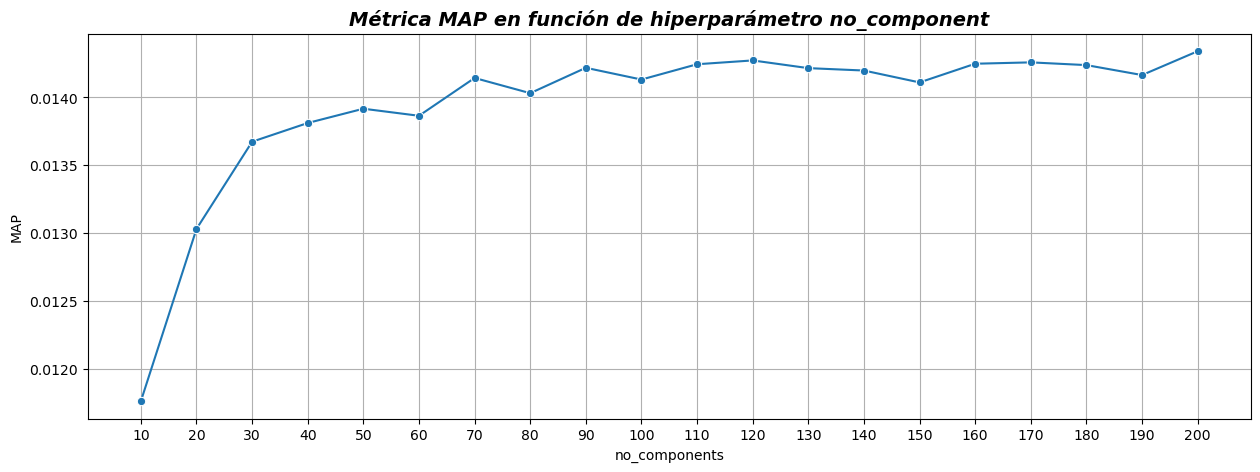

In [94]:
plt.clf()
plt.figure(figsize=(15,5))
sns.lineplot(data=df_MAP, x='Componente', y='MAP', marker="o")
plt.title('Métrica MAP en función de hiperparámetro no_component', fontdict={'fontsize': 14,'fontweight':'bold', 'style':'italic'})
#plt.xticks([x for x in range(df_MAP['Componente'].min(), df_MAP['Componente'].max() +1,1)], rotation=90)
plt.xticks([x for x in range(10, 201, 10)])
plt.xlabel('no_components')
plt.grid(0.6)
plt.show()

<b>no_components de 200 a 400</b>

In [130]:
# Definimos hiperparametros del modelo
random_state = 0
learning_rate = 0.03
components = [x for x in range(200, 401, 10)]
epochs = 10

MAP_dict = {}

for component in components:

    model = LightFM(loss='warp', random_state=random_state, learning_rate=learning_rate, no_components=component)
                       
    model = model.fit(interactions_matrix_csr_5, epochs=epochs)

    recomendations_dic = recomm_lightfm(model, interactions_matrix_5, interactions_matrix_csr_5, not_available_content, most_popular)

    recomendations_df = pd.DataFrame(recomendations_dic)
    
    MAP = calcular_MAP(ideal_recomms, recomendations_df)
    
    MAP_dict[component] = MAP

df_MAP = pd.DataFrame(MAP_dict.items(), columns=['Componente', 'MAP'])

100%|██████████| 87623/87623 [03:28<00:00, 420.05it/s] 
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
100%|██████████| 87623/87623 [03:24<00:00, 429.13it/s] 


<Figure size 432x288 with 0 Axes>

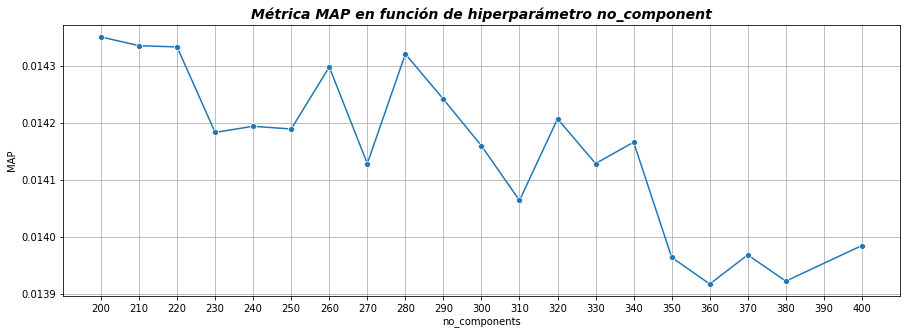

In [131]:
plt.clf()
plt.figure(figsize=(15,5))
sns.lineplot(data=df_MAP, x='Componente', y='MAP', marker="o")
plt.title('Métrica MAP en función de hiperparámetro no_component', fontdict={'fontsize': 14,'fontweight':'bold', 'style':'italic'})
#plt.xticks([x for x in range(df_MAP['Componente'].min(), df_MAP['Componente'].max() +1,1)], rotation=90)
plt.xticks([x for x in range(200, 401, 10)])
plt.xlabel('no_components')
plt.grid(0.6)
plt.show()

# Conclusiones

<b>Análisis exploratorio de datos:</b>
- Se analizó un dataset de reproducciones de videos con 3657801 filas y 7 columnas, junto con otro dataset con información de videos que posee 33144 filas y 30 columnas.
- Ambos datasets contenían nulos y registros duplicados, los cuales fueron eliminados.
- Las visualizaciones van desde el 01-01-2021 al 31-03-2021, siendo Marzo el mes con más visualizaciones y Enero el de menos.
- Hay un total de 112332 clientes y 113873 cuentas diferentes.
- La cantidad máxima de cuentas por cliente es de 3, pero más del 50% de los mismos tiene 1 sola cuenta.
- Hay 4061 contenidos diferentes.
- El número máximo de assets por contenido es de 205.
- La mayor parte de las reproducciones son desde el decodificador de flow (STB).
- La mayor parte de los videos son de origen estadounidense, seguidos por contenidos argentinos.
- Las series conforman la mayor parte del dataset, seguido por TV y películas.
- La duración máxima de un asset es de 305 minutos.
- La cantidad media de categorías distintas vistas por cuenta es de 5 y la mediana de 4.

<b>Sistema de Recomendación</b>
- Se presentaron 5 enfoques diferentes para calcular el rating de los contenidos.
- Por cada uno de estos enfoques se creó un modelo de recomendación con lightfm, los cuales fueron entrenados con datos anteriores al 01-03-2021 y testeados con datos posteriores a esa fecha.
- Se descartaron al momento de recomendar aquellos videos que caducan antes del 01-04-2021. 
- Para el cold start, se tomaron los 20 videos más populares.
- El modelo de recomendación construido con la opción 5, el cual consideraba si el usuario vió más de 30% del asset y si volvió a reproducir el contenido [resume] fue el que mejor métrica MAP (Mean Average Precision) obtuvo: 0.01413.
- A partir del modelo con mejor métrica se realizó una modificación de sus hiperparámetros, en específico el no_components, desde 10 a 400. Se obtuvo un gráfico de métrica MAP en función de no_component, y se observó que con un no_components=200 se lograba el mayor MAP, con un valor cercano a 0.015.
